In [1]:
import tensorflow
tf = tensorflow
print(tensorflow.__version__)

2.1.0


In [2]:
import numpy as np

Note for a serious speedup in computation, you need to ensure you have this processing on a GPU


See Tensorflow's [GPU installation guide](https://www.tensorflow.org/install/gpu)
if it is not working for you

In [3]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
tf.test.is_built_with_cuda()

True

In [5]:
#Possible fix to https://github.com/tensorflow/tensorflow/issues/24496
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [6]:
## Load the data
import pickle
with open('lotr_data_prep.pickle', 'rb') as handle:
    reload_data = pickle.load(handle)
    print(reload_data.keys())



dict_keys(['tokenizer', 'train_tokens'])


In [7]:
tokenizer = reload_data['tokenizer']
train_tokens = reload_data['train_tokens']

In [8]:
train_tokens.shape

(380554, 30)

In [9]:
#Now, if these are our sentences, then we want to split them
# so the first words are predicting the last word
predictors, label_int = (
    train_tokens[:,:-1], train_tokens[:,-1]
)

In [10]:
total_words = len(tokenizer.word_index) + 1 #word_index is a dict
total_words

8662

In [11]:
#However be careful with the num instances, once we go categorical
print(predictors.shape)
print(label_int.shape, "at", total_words, "words")

(380554, 29)
(380554,) at 8662 words


In [12]:
print((predictors.shape[0] * predictors.shape[1]) / (10**6), "M predictors")
print((label_int.shape[0] * total_words) / (10**6), "M labels")


11.036066 M predictors
3296.358748 M labels


In [13]:
#And then 'one-hot encode' these, to make output prediction per-word
import tensorflow.keras.utils as ku

label = ku.to_categorical(label_int, num_classes=total_words)

In [14]:
predictors

array([[   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,   69],
       [   0,    0,    0, ...,    0,   69,  170],
       ...,
       [   0,    0,    0, ...,   63,   55,    2],
       [   0,    0,   48, ...,   55,    2,  156],
       [   0,   48, 8660, ...,    2,  156,    4]])

In [15]:
label

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [16]:
# Simple Model - 2 layer
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(total_words, 100, input_length=predictors.shape[1])) #ormax_sequence_len-1))
model.add(tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(150)
))
model.add(tf.keras.layers.Dense(300))
model.add(tf.keras.layers.Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 29, 100)           866200    
_________________________________________________________________
bidirectional (Bidirectional (None, 300)               301200    
_________________________________________________________________
dense (Dense)                (None, 300)               90300     
_________________________________________________________________
dense_1 (Dense)              (None, 8662)              2607262   
Total params: 3,864,962
Trainable params: 3,864,962
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
#Optional checkpointing >>
import os
checkpoint_path = "training_lotr_2l/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    verbose=1,
)
# Note: """
# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.
# """
#<<



In [18]:
#For example if it fails after checkpointing halfway...
#ckpt = tf.train.Checkpoint(step=tf.Variable(1), net=model)
#manager = tf.train.CheckpointManager(ckpt, './training_1', max_to_keep=3)

#checkpoint_path = './training_1/cp.ckpt' #manager.latest_checkpoint ??
try:
    model.load_weights(checkpoint_path)
    print("Successfully loaded weights from:",checkpoint_path)
except ValueError as e:
    print("Couldn't load model weights:")
    print(repr(e))
    print("... continuing...")

Couldn't load model weights:
ValueError('Unsuccessful TensorSliceReader constructor: Failed to get matching files on training_lotr_2l/cp.ckpt: Not found: FindFirstFile failed for: training_lotr_2l : The system cannot find the path specified.\r\n; No such process')
... continuing...


In [19]:
PREDICTION_INPUT_LEN = model.get_input_shape_at(0)[1]
from tensorflow.keras.preprocessing.sequence import pad_sequences

def predict_word_prob(input_seqs):
    pr_probs = model.predict_proba(input_seqs)
    pr_outputs = [[
        (pr_probs[sen_i][index], word, index)
        for word, index in tokenizer.word_index.items()
    ] for sen_i in range(pr_probs.shape[0]) ]
    sorted_pr_outputs = [
        sorted(pr_output, reverse=True)
        for pr_output in pr_outputs
    ]
    return sorted_pr_outputs

def prepare_tokens(token_list):
    token_list = pad_sequences(
        [token_list],
        maxlen=PREDICTION_INPUT_LEN,
        padding='pre',
    )
    return token_list

def prepare_sentence(sentence_text):
    token_list = tokenizer.texts_to_sequences([sentence_text])[0]
    return token_list

def predict_for_sentence(sentence_text):
    tl = prepare_sentence(sentence_text)
    pt = prepare_tokens(tl)
    predict = predict_word_prob(pt)
    return predict

def generate_next_n_words(seed_text, next_words=30):
    gen_text = seed_text
    for i in range(next_words):
        next_words = predict_for_sentence(gen_text)[0]
        top_prediction = next_words[0][1]
        
        gen_text += ' '+top_prediction
    return gen_text


In [20]:
seed_text = "Frodo"
next_words = 60

gen_text = generate_next_n_words(seed_text,next_words)
print(seed_text, "->", gen_text)

Frodo -> Frodo curtain deadly deadly storey cheers deadly cheers puzzled puzzled puzzled impress cheers friends' budding impress dell cheers wardens cheers wardens friends' cheers wardens unscathed flies sing sing snowed conical conical such dells package risen maps package lingered ghost ethir reek reek temptation discussed blankets sheltered blankets hustled hustled lane lane botanical botanical ago ago chain uneventful most nail tearing await


In [21]:
#turn this into a training epoch callback
def generate_text_on_epoch_end(epoch, metrics, append_to_filename=None):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)
    seed_text = "Frodo"
    next_words = 60
    gen_text = generate_next_n_words(seed_text,next_words)
    
    print(seed_text, "->", gen_text)
    
    #Duplicate to file
    if append_to_filename:
        with open(append_to_filename,'a') as fout:
            print('----- Epoch: %d' % epoch, file=fout)
            print(metrics, file=fout)
            print(seed_text, "->", gen_text, file=fout)
    

from tensorflow.keras.callbacks import LambdaCallback
import functools
print_callback = LambdaCallback(
    on_epoch_end=functools.partial(
        generate_text_on_epoch_end, append_to_filename='gen_text_epochs.txt',
    )
)

In [22]:
training_callbacks = [print_callback]

USE_CHECKPOINTS = True
if USE_CHECKPOINTS:
    training_callbacks.append(checkpoint_callback)
training_callbacks

In [23]:
import random
rng = random.Random(42)
shuffle_order = list(range(predictors.shape[0]))
rng.shuffle(shuffle_order)
print("Shuffle order:", shuffle_order[:10], "...")

Shuffle order: [61605, 4700, 179132, 23845, 186399, 99781, 193411, 365485, 19800, 329854] ...


In [24]:
x,y_int = predictors[shuffle_order],label_int[shuffle_order]
y = ku.to_categorical(y_int, num_classes=total_words)

In [25]:
N_EPOCHS = 50
history = model.fit(
    x, y,
    epochs=N_EPOCHS,
    verbose=1,
    callbacks = training_callbacks,
)

Train on 380554 samples
Epoch 1/50
380544/380554 [============================>.] - ETA: 0s - loss: 5.3384 - accuracy: 0.1450
----- Generating text after Epoch: 0
Frodo -> Frodo was a good deal of his own friends and he was not to be seen and he was aware that he was not to be seen and he was aware that he was not a good deal of his own · he was not a good deal of his own friends · he was not a good deal of his

Epoch 00001: saving model to training_lotr_2l/cp.ckpt
380554/380554 [==============================] - 215s 565us/sample - loss: 5.3384 - accuracy: 0.1450
Epoch 2/50
380480/380554 [============================>.] - ETA: 0s - loss: 4.5501 - accuracy: 0.1997
----- Generating text after Epoch: 1
Frodo -> Frodo was staring at the fire and the hobbits followed him and then suddenly as if he had been able to see the road and the road and the road flowed out of the open woods · the hobbits had been chosen to find them · the hobbits were mostly very uncomfortable and they were not in t

Epoch 15/50
380544/380554 [============================>.] - ETA: 0s - loss: 1.5038 - accuracy: 0.6376
----- Generating text after Epoch: 14
Frodo -> Frodo looked at him unhappily · ‘ i am sorry to take the ring to you that are all gate now ' said pippin · 'i am mr underhill if any name must be given to seek a message for the hour of lórien · i don't know why he stories you ask not · but why do you believe that

Epoch 00015: saving model to training_lotr_2l/cp.ckpt
380554/380554 [==============================] - 222s 584us/sample - loss: 1.5038 - accuracy: 0.6376
Epoch 16/50
380448/380554 [============================>.] - ETA: 0s - loss: 1.4534 - accuracy: 0.6475
----- Generating text after Epoch: 15
Frodo -> Frodo and aragorn followed frodo and aragorn who had all their sense on the side and half that they had been expected to get angry thoughtfully · he was delighted in the great hearts of his way and he had been out of a good track for a while · he looked at strider with bilbo in 

Epoch 29/50
380480/380554 [============================>.] - ETA: 0s - loss: 1.1759 - accuracy: 0.7111
----- Generating text after Epoch: 28
Frodo -> Frodo was just yielding to the temptation to lie down again when they saw a hole and after all the darkness was less than when a hole was in the darkness · but boromir gone and the fallen brown tower you suffer of hands and he might be often rising on the spot i spoke · i have not spoken to

Epoch 00029: saving model to training_lotr_2l/cp.ckpt
380554/380554 [==============================] - 205s 539us/sample - loss: 1.1759 - accuracy: 0.7111
Epoch 30/50
380544/380554 [============================>.] - ETA: 0s - loss: 1.1618 - accuracy: 0.7148
----- Generating text after Epoch: 29
Frodo -> Frodo was in the way by a door dark had at the end of the lighter and when the door was heard again but he did not get out the figure of a mighty rings of old winyards · there they stood and standing outside leaving the green and green path filled with

380554/380554 [==============================] - 208s 546us/sample - loss: 1.0696 - accuracy: 0.7365
Epoch 43/50
380448/380554 [============================>.] - ETA: 0s - loss: 1.0629 - accuracy: 0.7377
----- Generating text after Epoch: 42
Frodo -> Frodo looked at it and puckered his brows · fear nothing to leave the boats they were black smoke which were not reached by the rider · they were far away they were turned closer even far from than more than a trees beyond the downs · many of them were blue and the remote were walked stood silent · i

Epoch 00043: saving model to training_lotr_2l/cp.ckpt
380554/380554 [==============================] - 247s 649us/sample - loss: 1.0628 - accuracy: 0.7377
Epoch 44/50
380512/380554 [============================>.] - ETA: 0s - loss: 1.0586 - accuracy: 0.7393
----- Generating text after Epoch: 43
Frodo -> Frodo was here when his first gaffer began to get bag end for he had not finished so indeed a spell and then suddenly he knew that he was goi

In [26]:
print(dir(history))
print(history.params)
history.history

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_chief_worker_only', '_keras_api_names', '_keras_api_names_v1', 'epoch', 'history', 'model', 'on_batch_begin', 'on_batch_end', 'on_epoch_begin', 'on_epoch_end', 'on_predict_batch_begin', 'on_predict_batch_end', 'on_predict_begin', 'on_predict_end', 'on_test_batch_begin', 'on_test_batch_end', 'on_test_begin', 'on_test_end', 'on_train_batch_begin', 'on_train_batch_end', 'on_train_begin', 'on_train_end', 'params', 'set_model', 'set_params', 'validation_data']
{'batch_size': 32, 'epochs': 50, 'steps': 11893, 'samples': 380554, 'verbose': 1, 'do_validation': False, 'metrics': ['loss', 'accuracy']}


{'loss': [5.338413194123803,
  4.550139304811298,
  4.023688664192731,
  3.4948173825816258,
  3.0286528245889146,
  2.6680716974933723,
  2.396794513198017,
  2.188992718804689,
  2.0203836345267634,
  1.8881184260954709,
  1.7790953406711114,
  1.6874294929966829,
  1.6131075080792803,
  1.550920154251495,
  1.5037936961883218,
  1.4533676535690392,
  1.4184853696175064,
  1.3821493248269983,
  1.3544080857609675,
  1.3255742659198624,
  1.3031455535729966,
  1.282001404307752,
  1.2636891061612858,
  1.2451009386539713,
  1.2299641719635768,
  1.213578065202996,
  1.199046019019189,
  1.1864266473430758,
  1.1759462943739403,
  1.1617629536979601,
  1.1542618729361422,
  1.1462841456637753,
  1.1326097443624579,
  1.1247255603681225,
  1.1172441671495026,
  1.1118835082949512,
  1.1024126553123599,
  1.0978802451685086,
  1.087781434174996,
  1.0835270817198106,
  1.0754186316901826,
  1.0695698031283922,
  1.062844529763234,
  1.0586052668345425,
  1.0574120319745985,
  1.049102882

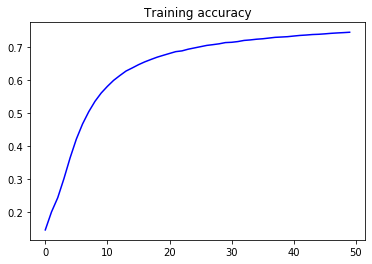

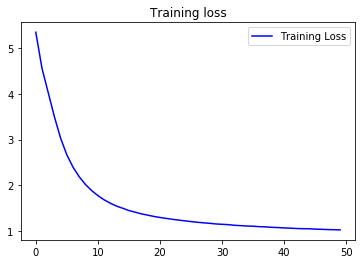

In [28]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [29]:
#Save the model
import time
now_timestamp = int(time.time())
save_filename = 'lotr_prediction_model_%s'% now_timestamp
model.save(save_filename)

#Note re file format: args, from docs (@param):
#  save_format: Either 'tf' or 'h5', indicating whether to save the model to Tensorflow SavedModel or HDF5. Defaults to 'tf' in TF 2.X, and 'h5' in TF 1.X.

#Note: Saved models can be reinstantiated via keras.models.load_model

## NOTE:
## !pip install -q pyyaml h5py  # Required to save models in HDF5 format

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: lotr_prediction_model_1580426580\assets


In [30]:
#Need to save the tokeniser as well for encoding:
# then can use eg: tokenizer.texts_to_sequences([the_sentence])[0]
dir(tokenizer)

import pickle
# saving
with open('lotr_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle)
with open('lotr_train_history_history.pickle', 'wb') as handle:
    pickle.dump(history.history, handle)
    #pickle.dump(history_total, handle)
    

In [32]:
print(type(history))
history.__dict__

<class 'tensorflow.python.keras.callbacks.History'>


{'validation_data': None,
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x22e2955bec8>,
 '_chief_worker_only': None,
 'params': {'batch_size': 32,
  'epochs': 50,
  'steps': 11893,
  'samples': 380554,
  'verbose': 1,
  'do_validation': False,
  'metrics': ['loss', 'accuracy']},
 'epoch': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 'history': {'loss': [5.338413194123803,
   4.550139304811298,
   4.023688664192731,
   3.4948173825816258,
   3.0286528245889146,
   2.6680716974933723,
   2.396794513198017,
   2.188992718804689,
   2.0203836345267634,
   1.8881184260954709,
   1.7790953406711114,
   1.6874294929966829,
   1.6131075080792803,
   1.550920154251495,
   1.5037936961883218,
   1.4533676535690392,
   1.4184853696175

In [33]:
history.model

In [34]:
history.on_epoch_end

<bound method History.on_epoch_end of <tensorflow.python.keras.callbacks.History object at 0x0000022E467B4748>>

In [35]:
N_EPOCHS = 50
history2 = model.fit(
    x, y,
    epochs=N_EPOCHS,
    verbose=1,
    callbacks = training_callbacks,
)
history2.history

Train on 380554 samples
Epoch 1/50
380544/380554 [============================>.] - ETA: 0s - loss: 1.0283 - accuracy: 0.7465
----- Generating text after Epoch: 0
Frodo -> Frodo lay down again but he saw that it was getting hot and straight that if you want to know where i am going on now to make your mind · even as i wish to set me alone · it was singing that i ever saw before them · i don't like this great ring · his eyes were shining

Epoch 00001: saving model to training_lotr_2l/cp.ckpt
380554/380554 [==============================] - 256s 673us/sample - loss: 1.0283 - accuracy: 0.7465
Epoch 2/50
380480/380554 [============================>.] - ETA: 0s - loss: 1.0243 - accuracy: 0.7480
----- Generating text after Epoch: 1
Frodo -> Frodo was just trying to put his claim to the spot but the hobbits woke like a rather deadly bring garden to him to grasp you gandalf with the thought · the others looked at him turned to find fair and as soon as the ponies were tom in the inhabitants of 

Epoch 15/50
380448/380554 [============================>.] - ETA: 0s - loss: 0.9873 - accuracy: 0.7572
----- Generating text after Epoch: 14
Frodo -> Frodo woke suddenly and found that a tree root had nearly good off a good deal of an eagle an hunting eagle up from the boughs of high hill · he whispered springing up and he is right · the riders did not not now see us ' said the dwarf · did you know what you mean · 'or at

Epoch 00015: saving model to training_lotr_2l/cp.ckpt
380554/380554 [==============================] - 236s 621us/sample - loss: 0.9874 - accuracy: 0.7572
Epoch 16/50
380512/380554 [============================>.] - ETA: 0s - loss: 0.9845 - accuracy: 0.7574
----- Generating text after Epoch: 15
Frodo -> Frodo said sam and pippin with only a look of relief and a laugh in a pile that behind was a hilt throwing a letter and slipped from over it · all was moria from the burden in he free · arrows whined and whistled filled the world at the sunlight deep upon the west · he

380554/380554 [==============================] - 234s 615us/sample - loss: 0.9614 - accuracy: 0.7632
Epoch 29/50
380544/380554 [============================>.] - ETA: 0s - loss: 0.9606 - accuracy: 0.7633
----- Generating text after Epoch: 28
Frodo -> Frodo woke suddenly and found himself lying in the sky above him again but for some sound in his arms of rest as small his eyes opened his eyes · he did not prove heat · as far as it went down the hearts of the last land of the river · and at last they set off · three ·

Epoch 00029: saving model to training_lotr_2l/cp.ckpt
380554/380554 [==============================] - 232s 610us/sample - loss: 0.9606 - accuracy: 0.7633
Epoch 30/50
380448/380554 [============================>.] - ETA: 0s - loss: 0.9556 - accuracy: 0.7660
----- Generating text after Epoch: 29
Frodo -> Frodo was sitting at a table with a lot of papers in front of them and danced round them little in the water in the next hill · frodo stood down and flung himself from the 

380554/380554 [==============================] - 214s 563us/sample - loss: 0.9402 - accuracy: 0.7698
Epoch 43/50
380448/380554 [============================>.] - ETA: 0s - loss: 0.9406 - accuracy: 0.7686
----- Generating text after Epoch: 42
Frodo -> Frodo was silent for some time and then he began not sleep again with the others about the others until they had set the watch and had been stirring and they not look about them in any sunlit land · to the left hand of isildur was watched only in the tree but a heavy weight was upon and from it

Epoch 00043: saving model to training_lotr_2l/cp.ckpt
380554/380554 [==============================] - 233s 613us/sample - loss: 0.9407 - accuracy: 0.7686
Epoch 44/50
380480/380554 [============================>.] - ETA: 0s - loss: 0.9420 - accuracy: 0.7690
----- Generating text after Epoch: 43
Frodo -> Frodo was thinking of a strange fashion in foreign parts they were many more than other clear and dreadful but the rest in the glade at all costs t

{'loss': [1.0283275422617664,
  1.024249182655078,
  1.019856328812043,
  1.016697897561332,
  1.014682970850576,
  1.0134909137735513,
  1.0066013465595427,
  1.0042130981323285,
  1.0042910206154196,
  0.9985795547094894,
  0.9970210288602455,
  0.9962800917750753,
  0.9904811450732991,
  0.989553547231237,
  0.9874093236583001,
  0.9845047380775781,
  0.9806601880694683,
  0.9793630199090753,
  0.9766001102204206,
  0.9772547860947294,
  0.9739511526889535,
  0.9716617901059701,
  0.9710925245917552,
  0.9667769126775009,
  0.9689822140423168,
  0.966762081719284,
  0.9622847851980816,
  0.961417852334274,
  0.9605753252238952,
  0.9556888367947455,
  0.9562861589100803,
  0.9519257690146613,
  0.9521014914869266,
  0.9540935643161975,
  0.9531382518125207,
  0.9473430508712759,
  0.9488523348441443,
  0.9457054612259123,
  0.9467936685081011,
  0.9429627171270794,
  0.944734432466655,
  0.9401546403062193,
  0.940677898942087,
  0.9419923416469708,
  0.9362930329587746,
  0.9367175

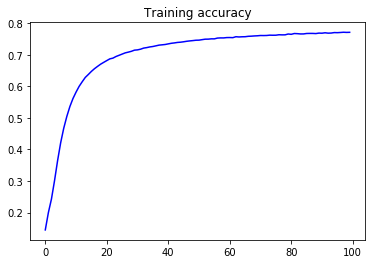

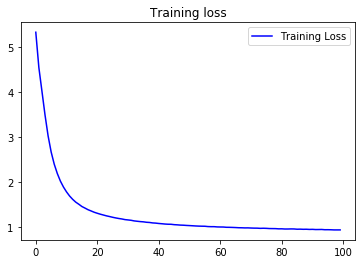

In [36]:
accuracy2 = accuracy + history2.history['accuracy']
loss2 = loss + history2.history['loss']

epochs = range(len(accuracy2))

plt.plot(epochs, accuracy2, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss2, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [37]:
save_filename = 'lotr_prediction_model_%s'% int(time.time())
model.save(save_filename)

INFO:tensorflow:Assets written to: lotr_prediction_model_1580492244\assets


In [38]:

seed_text = "Frodo"
next_words = 500

gen_text = generate_next_n_words(seed_text,next_words)
print(seed_text, "->", gen_text)

Frodo -> Frodo said nothing but sam ‘ how i mean to déagol ’ said the wizard looking round as quickly as if with a relief of relief · suddenly he was aware that he was himself brown and up the and rest gandalf behind · he stepped down to the pavilion · he was frodo in the last homely house like a answered of little feet but there was a cry of feeling going beyond simple but the biting lanterns were drinking and the river with small river and wrought eyes and age and for the kings ' · a moment has come out with his good dangerous he already accident ' · said frodo · the story just replied that an faithful with mr frodo · and quite accident i need too likely that he made that you worry about anything · i don't know what i mean · no time i would tell you a really like away i much came knowledge to say my part in that i think i shall ever get there · but i had forgotten it if you were present · ‘ i am rather shaken with me · i know one of the little folk who we go with him · how it would b